In [2]:
!pip install torchtext
!pip install dgl

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

pd.set_option('display.max_rows', 30000)
pd.set_option('display.max_columns', 300)

import torch
import torchtext

import dgl

     |████████████████████████████████| 6.9 MB 20.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 3.6 MB 17.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [3]:
dflink=pd.read_csv('fulldfR.csv')

In [4]:
dfnode=pd.read_csv('nodeInfo.csv')

In [5]:
dflink.drop(['Unnamed: 0'],axis=1,inplace=True)
dfnode.rename(columns={'Unnamed: 0':'tag'},inplace=True)
dflink.head(1)
dfnode.head(1)

,vertices,neg,ne,po,m,rumor,not_rumor,v1,v2,key1,key2,max,max_label
0,"('#rt', '#believe')",6,8,0,0,1,13,#rt,#believe,433,410,8,1


,tag,neg,ne,po,m,rumor,not_rumor
0,#rt,1634,1764,237,4,71,3568


In [6]:
len(dflink)
len(dfnode)

43004

2882

In [7]:
glove=torchtext.vocab.GloVe(name='twitter.27B',dim=100)

In [8]:
dfnode['word']=dfnode['tag'].apply(lambda x: x.replace('#',''))

temp=[]
for word in dfnode['word']:
    em=glove[word].tolist()
    temp.append(em)

In [9]:
len(temp)

2882

In [10]:
dfnode['embeddings']=temp

In [11]:
dfnode.head(1)

,tag,neg,ne,po,m,rumor,not_rumor,word,embeddings
0,#rt,1634,1764,237,4,71,3568,rt,"[0.6047000288963318, 0.8954200148582458, 0.279..."


In [12]:
l=list(dflink.v1)+list(dflink.v2)
s=set(l)
len(s)
l=list(s)

2881

In [13]:
dfkey=pd.DataFrame()
dfkey['tag']=l

In [14]:
dfkey.head(1)
dfkey['key']=[i for i in range(0,len(dfkey))]

,tag
0,#rapidtest


In [15]:
dfkey.head(1)
len(dfkey)

,tag,key
0,#rapidtest,0


2881

In [16]:
a=dfkey.merge(dfnode)

In [17]:
a.head(1)
len(a)

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


2877

In [18]:
dflink.head(1)

,vertices,neg,ne,po,m,rumor,not_rumor,v1,v2,key1,key2,max,max_label
0,"('#rt', '#believe')",6,8,0,0,1,13,#rt,#believe,433,410,8,1


In [19]:
len(dflink)
dflink=dflink.merge(a,left_on='v1',right_on='tag')
len(dflink)

43004

42998

In [20]:
len(dflink)
dflink=dflink.merge(a,left_on='v2',right_on='tag')
len(dflink)

42998

42991

In [21]:
# the tags in dflink are the same with the tags in a 
a.head(1)

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
dflinks=dflink[['v1','embeddings_x','v2','embeddings_y',\
                'rumor_x','not_rumor_x']].copy()
dflinks.head(1)

,v1,embeddings_x,v2,embeddings_y,rumor_x,not_rumor_x
0,#rt,"[0.6047000288963318, 0.8954200148582458, 0.279...",#believe,"[0.195250004529953, 0.8961700201034546, 0.2282...",1,13


In [23]:
dflinks.rename(columns={'embeddings_x':'em_v1','embeddings_y':'em_v2',\
                       'rumor_x':'rumor_link','not_rumor_x':'not_rumor_link'},\
              inplace=True)
dflinks.head(1)

,v1,em_v1,v2,em_v2,rumor_link,not_rumor_link
0,#rt,"[0.6047000288963318, 0.8954200148582458, 0.279...",#believe,"[0.195250004529953, 0.8961700201034546, 0.2282...",1,13


In [24]:
temp=[]
for i in range(0,len(dflinks)):
    t1=dflinks['rumor_link'][i]
    t2=dflinks['not_rumor_link'][i]
    t3=t1/(t1+t2)
    temp.append(t3)
    
dflinks['rate']=temp

In [25]:
dflinks.head(1)

,v1,em_v1,v2,em_v2,rumor_link,not_rumor_link,rate
0,#rt,"[0.6047000288963318, 0.8954200148582458, 0.279...",#believe,"[0.195250004529953, 0.8961700201034546, 0.2282...",1,13,0.071429


In [26]:
dflinks.rate.mean()

0.037917182988705694

In [27]:
dflinks['label']=dflinks['rate'].apply(lambda x: 1 if x>0.038 else 0)

In [28]:
from collections import Counter
Counter(dflinks.label)

Counter({1: 2105, 0: 40886})

In [30]:
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

     |████████████████████████████████| 167 kB 20.3 MB/s eta 0:00:01
  Using cached scikit_learn-0.23.2-cp36-cp36m-manylinux1_x86_64.whl (6.8 MB)
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [31]:
A=list(dflinks.em_v1)
A=pd.DataFrame(A)

In [32]:
B=list(dflinks.em_v2)
B=pd.DataFrame(B)
B.columns=list(range(100,200))

In [33]:
A.shape

(42991, 100)

In [34]:
Smote2B=dflinks[['v1','v2','label']]

In [35]:
Smote2B.head(1)

,v1,v2,label
0,#rt,#believe,1


In [36]:
Smote2B=pd.concat([Smote2B,A],axis=1)
Smote2B.shape

(42991, 103)

In [37]:
Smote2B.head(1)

,v1,v2,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,#rt,#believe,1,0.6047,0.89542,0.27923,0.033489,0.15873,0.18522,0.30722,0.47445,0.44484,0.7045,0.39528,-0.19818,-2.3884,0.095433,0.10782,0.26263,0.36582,-0.6385,-0.22938,-0.34722,0.10977,0.37367,-0.068053,-0.39421,0.43471,-2.1794,-0.47111,0.087237,0.57989,-0.020883,-0.0695,0.25771,-0.5019,0.41154,1.2178,0.47976,-0.31574,0.52983,0.041575,0.44973,-1.5363,-0.096062,-0.27531,0.52771,0.028587,0.047935,-0.5973,-0.051772,0.11377,-0.4049,-0.54857,-0.65916,-0.38132,-0.39519,0.42961,0.74531,-0.50838,0.40392,0.62699,-0.24798,-0.25386,0.21867,-0.072132,-0.51783,-0.054186,-0.66391,-0.58224,0.060621,-0.54001,0.72242,0.13349,-0.070261,-0.059061,-0.035474,-0.53649,-0.3755,0.11234,-0.3409,-0.13406,0.007887,0.81973,-0.075774,0.10947,0.26919,-0.069167,0.27475,-0.90546,0.54632,-0.6847,0.35787,-0.015019,0.42209,-0.06252,-0.33265,-0.60945,-0.23269,-0.40932,0.51566,0.84726,0.020946


In [38]:
Smote2B=pd.concat([Smote2B,B],axis=1)

In [39]:
Smote2B.head(1)

,v1,v2,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,#rt,#believe,1,0.6047,0.89542,0.27923,0.033489,0.15873,0.18522,0.30722,0.47445,0.44484,0.7045,0.39528,-0.19818,-2.3884,0.095433,0.10782,0.26263,0.36582,-0.6385,-0.22938,-0.34722,0.10977,0.37367,-0.068053,-0.39421,0.43471,-2.1794,-0.47111,0.087237,0.57989,-0.020883,-0.0695,0.25771,-0.5019,0.41154,1.2178,0.47976,-0.31574,0.52983,0.041575,0.44973,-1.5363,-0.096062,-0.27531,0.52771,0.028587,0.047935,-0.5973,-0.051772,0.11377,-0.4049,-0.54857,-0.65916,-0.38132,-0.39519,0.42961,0.74531,-0.50838,0.40392,0.62699,-0.24798,-0.25386,0.21867,-0.072132,-0.51783,-0.054186,-0.66391,-0.58224,0.060621,-0.54001,0.72242,0.13349,-0.070261,-0.059061,-0.035474,-0.53649,-0.3755,0.11234,-0.3409,-0.13406,0.007887,0.81973,-0.075774,0.10947,0.26919,-0.069167,0.27475,-0.90546,0.54632,-0.6847,0.35787,-0.015019,0.42209,-0.06252,-0.33265,-0.60945,-0.23269,-0.40932,0.51566,0.84726,0.020946,0.19525,0.89617,0.22821,0.63518,-0.70839,-0.011323,0.92501,-0.17742,-0.020288,0.49284,0.41775,-0.52065,-4.2043,0.84009,-0.24335,-0.06989,-0.31298,0.36754,0.47112,0.57206,0.59132,-0.17664,0.42564,0.48229,0.40946,-0.83646,0.36686,-0.24538,0.13244,-0.29066,-0.38602,-0.55822,0.10684,0.19424,0.069472,0.42863,0.25874,-0.27356,-0.57201,0.27914,-0.69152,-0.20337,0.48979,-0.33717,0.40298,-0.020644,0.10159,-0.77235,-0.23793,-0.26272,-0.57054,0.85216,0.66403,0.009447,0.27247,-0.53516,-0.47101,0.29318,-0.35322,-0.57052,0.64503,0.15509,-0.16464,0.20202,0.39058,0.53661,-0.35763,0.34521,-0.29123,-0.082283,-0.27913,0.1491,0.25813,0.23189,0.17817,-0.34999,-0.43301,-0.081137,0.12282,0.53281,1.2064,0.043001,0.21776,0.52524,0.17676,0.49993,-0.27142,0.034736,-0.30927,0.25019,-0.20913,0.39588,0.57821,0.0866,-0.66691,0.76625,-0.26714,-0.33894,0.5566,-0.37453


In [40]:
name1=list(range(0,100))
name2=list(range(100,200))

In [41]:
x=Smote2B[name1+name2]
x.shape
y=Smote2B['label']
Counter(y)

(42991, 200)

Counter({1: 2105, 0: 40886})

In [42]:
smo=SMOTE(random_state=1,sampling_strategy=0.07)
x_smote,y_smote=smo.fit_sample(x,y)

In [43]:
len(a)
a.head(1)
temp=[]
for i in range(0,len(a)):
    t1=a.rumor[i]
    t2=a.not_rumor[i]
    t3=t1/(t1+t2)
    temp.append(t3)
a['rate']=temp
a.rate.mean()

2877

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


0.03663089426361042

In [44]:
a['label']=a['rate'].apply(lambda x: 1 if x>0.037 else 0)

In [45]:
Counter(y_smote)
Counter(a.label)

Counter({1: 2862, 0: 40886})

Counter({0: 2552, 1: 325})

In [46]:
temp=[i for i in range(0,len(a))]
a['key']=temp
a.head(1)

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0


In [47]:
a.key.min()
a.key.max()
len(a)
dflinks.head(1)
dflink.head(1)

0

2876

2877

,v1,em_v1,v2,em_v2,rumor_link,not_rumor_link,rate,label
0,#rt,"[0.6047000288963318, 0.8954200148582458, 0.279...",#believe,"[0.195250004529953, 0.8961700201034546, 0.2282...",1,13,0.071429,1


,vertices,neg_x,ne_x,po_x,m_x,rumor_x,not_rumor_x,v1,v2,key1,key2,max,max_label,tag_x,key_x,neg_y,ne_y,po_y,m_y,rumor_y,not_rumor_y,word_x,embeddings_x,tag_y,key_y,neg,ne,po,m,rumor,not_rumor,word_y,embeddings_y
0,"('#rt', '#believe')",6,8,0,0,1,13,#rt,#believe,433,410,8,1,#rt,2251,1634,1764,237,4,71,3568,rt,"[0.6047000288963318, 0.8954200148582458, 0.279...",#believe,94,21,19,3,0,5,38,believe,"[0.195250004529953, 0.8961700201034546, 0.2282..."


In [48]:
smotedf=pd.concat([x_smote,y_smote],axis=1)

In [49]:
smotedf.head(1)
len(smotedf)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,label
0,0.6047,0.89542,0.27923,0.033489,0.15873,0.18522,0.30722,0.47445,0.44484,0.7045,0.39528,-0.19818,-2.3884,0.095433,0.10782,0.26263,0.36582,-0.6385,-0.22938,-0.34722,0.10977,0.37367,-0.068053,-0.39421,0.43471,-2.1794,-0.47111,0.087237,0.57989,-0.020883,-0.0695,0.25771,-0.5019,0.41154,1.2178,0.47976,-0.31574,0.52983,0.041575,0.44973,-1.5363,-0.096062,-0.27531,0.52771,0.028587,0.047935,-0.5973,-0.051772,0.11377,-0.4049,-0.54857,-0.65916,-0.38132,-0.39519,0.42961,0.74531,-0.50838,0.40392,0.62699,-0.24798,-0.25386,0.21867,-0.072132,-0.51783,-0.054186,-0.66391,-0.58224,0.060621,-0.54001,0.72242,0.13349,-0.070261,-0.059061,-0.035474,-0.53649,-0.3755,0.11234,-0.3409,-0.13406,0.007887,0.81973,-0.075774,0.10947,0.26919,-0.069167,0.27475,-0.90546,0.54632,-0.6847,0.35787,-0.015019,0.42209,-0.06252,-0.33265,-0.60945,-0.23269,-0.40932,0.51566,0.84726,0.020946,0.19525,0.89617,0.22821,0.63518,-0.70839,-0.011323,0.92501,-0.17742,-0.020288,0.49284,0.41775,-0.52065,-4.2043,0.84009,-0.24335,-0.06989,-0.31298,0.36754,0.47112,0.57206,0.59132,-0.17664,0.42564,0.48229,0.40946,-0.83646,0.36686,-0.24538,0.13244,-0.29066,-0.38602,-0.55822,0.10684,0.19424,0.069472,0.42863,0.25874,-0.27356,-0.57201,0.27914,-0.69152,-0.20337,0.48979,-0.33717,0.40298,-0.020644,0.10159,-0.77235,-0.23793,-0.26272,-0.57054,0.85216,0.66403,0.009447,0.27247,-0.53516,-0.47101,0.29318,-0.35322,-0.57052,0.64503,0.15509,-0.16464,0.20202,0.39058,0.53661,-0.35763,0.34521,-0.29123,-0.082283,-0.27913,0.1491,0.25813,0.23189,0.17817,-0.34999,-0.43301,-0.081137,0.12282,0.53281,1.2064,0.043001,0.21776,0.52524,0.17676,0.49993,-0.27142,0.034736,-0.30927,0.25019,-0.20913,0.39588,0.57821,0.0866,-0.66691,0.76625,-0.26714,-0.33894,0.5566,-0.37453,1


43748

In [50]:
em1=smotedf[name1]
em2=smotedf[name2]

In [51]:
# emlist1 and emlist2 is the embeddings after smote
em1.head(1)
temp=em1.values
emlist1=temp.tolist()

em2.head(1)
temp=em2.values
emlist2=temp.tolist()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.6047,0.89542,0.27923,0.033489,0.15873,0.18522,0.30722,0.47445,0.44484,0.7045,0.39528,-0.19818,-2.3884,0.095433,0.10782,0.26263,0.36582,-0.6385,-0.22938,-0.34722,0.10977,0.37367,-0.068053,-0.39421,0.43471,-2.1794,-0.47111,0.087237,0.57989,-0.020883,-0.0695,0.25771,-0.5019,0.41154,1.2178,0.47976,-0.31574,0.52983,0.041575,0.44973,-1.5363,-0.096062,-0.27531,0.52771,0.028587,0.047935,-0.5973,-0.051772,0.11377,-0.4049,-0.54857,-0.65916,-0.38132,-0.39519,0.42961,0.74531,-0.50838,0.40392,0.62699,-0.24798,-0.25386,0.21867,-0.072132,-0.51783,-0.054186,-0.66391,-0.58224,0.060621,-0.54001,0.72242,0.13349,-0.070261,-0.059061,-0.035474,-0.53649,-0.3755,0.11234,-0.3409,-0.13406,0.007887,0.81973,-0.075774,0.10947,0.26919,-0.069167,0.27475,-0.90546,0.54632,-0.6847,0.35787,-0.015019,0.42209,-0.06252,-0.33265,-0.60945,-0.23269,-0.40932,0.51566,0.84726,0.020946


,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.19525,0.89617,0.22821,0.63518,-0.70839,-0.011323,0.92501,-0.17742,-0.020288,0.49284,0.41775,-0.52065,-4.2043,0.84009,-0.24335,-0.06989,-0.31298,0.36754,0.47112,0.57206,0.59132,-0.17664,0.42564,0.48229,0.40946,-0.83646,0.36686,-0.24538,0.13244,-0.29066,-0.38602,-0.55822,0.10684,0.19424,0.069472,0.42863,0.25874,-0.27356,-0.57201,0.27914,-0.69152,-0.20337,0.48979,-0.33717,0.40298,-0.020644,0.10159,-0.77235,-0.23793,-0.26272,-0.57054,0.85216,0.66403,0.009447,0.27247,-0.53516,-0.47101,0.29318,-0.35322,-0.57052,0.64503,0.15509,-0.16464,0.20202,0.39058,0.53661,-0.35763,0.34521,-0.29123,-0.082283,-0.27913,0.1491,0.25813,0.23189,0.17817,-0.34999,-0.43301,-0.081137,0.12282,0.53281,1.2064,0.043001,0.21776,0.52524,0.17676,0.49993,-0.27142,0.034736,-0.30927,0.25019,-0.20913,0.39588,0.57821,0.0866,-0.66691,0.76625,-0.26714,-0.33894,0.5566,-0.37453


In [52]:
len(emlist1)
len(emlist2)
type(emlist1[0])
type(emlist2[0])
a.head(1)

43748

43748

list

list

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0


In [53]:
emlist=list(a.embeddings)

In [54]:
len(emlist)

2877

In [55]:
NewWordEm=[]
ini=2877
src=[]
dst=[]
f1=0
f2=0
for i in range(0,len(emlist1)):
    if emlist1[i] not in NewWordEm and emlist2[i] not in NewWordEm:
        if emlist1[i] not in emlist and emlist2[i] not in emlist:
            NewWordEm.append(emlist1[i])
            NewWordEm.append(emlist2[i])
            t1=ini+NewWordEm.index(emlist1[i])
            t2=ini+NewWordEm.index(emlist2[i])
            src.append(t1)
            dst.append(t2)
         
        if emlist1[i] not in emlist and emlist2[i] in emlist:
            NewWordEm.append(emlist1[i])
            t1=ini+NewWordEm.index(emlist1[i])
            t2=emlist.index(emlist2[i])
            src.append(t1)
            dst.append(t2)
            f1=f1+1
            
        if emlist1[i] in emlist and emlist2[i] not in emlist:
            NewWordEm.append(emlist2[i])
            t1=emlist.index(emlist1[i])
            t2=ini+NewWordEm.index(emlist2[i])
            src.append(t1)
            dst.append(t2)
            f2=f2+1
        
        
        
        if i%10000==0:
            print(i)
print('\n')
f1
f2

0
10000
20000
30000
40000




295

323

In [56]:
len(src)
len(dst)
len(NewWordEm)
len(emlist)
len(dflink)

667

667

716

2877

42991

In [ ]:
295
323

In [57]:
Smote2B.head(1)
a.head(1)
len(Smote2B)
len(a)

,v1,v2,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,#rt,#believe,1,0.6047,0.89542,0.27923,0.033489,0.15873,0.18522,0.30722,0.47445,0.44484,0.7045,0.39528,-0.19818,-2.3884,0.095433,0.10782,0.26263,0.36582,-0.6385,-0.22938,-0.34722,0.10977,0.37367,-0.068053,-0.39421,0.43471,-2.1794,-0.47111,0.087237,0.57989,-0.020883,-0.0695,0.25771,-0.5019,0.41154,1.2178,0.47976,-0.31574,0.52983,0.041575,0.44973,-1.5363,-0.096062,-0.27531,0.52771,0.028587,0.047935,-0.5973,-0.051772,0.11377,-0.4049,-0.54857,-0.65916,-0.38132,-0.39519,0.42961,0.74531,-0.50838,0.40392,0.62699,-0.24798,-0.25386,0.21867,-0.072132,-0.51783,-0.054186,-0.66391,-0.58224,0.060621,-0.54001,0.72242,0.13349,-0.070261,-0.059061,-0.035474,-0.53649,-0.3755,0.11234,-0.3409,-0.13406,0.007887,0.81973,-0.075774,0.10947,0.26919,-0.069167,0.27475,-0.90546,0.54632,-0.6847,0.35787,-0.015019,0.42209,-0.06252,-0.33265,-0.60945,-0.23269,-0.40932,0.51566,0.84726,0.020946,0.19525,0.89617,0.22821,0.63518,-0.70839,-0.011323,0.92501,-0.17742,-0.020288,0.49284,0.41775,-0.52065,-4.2043,0.84009,-0.24335,-0.06989,-0.31298,0.36754,0.47112,0.57206,0.59132,-0.17664,0.42564,0.48229,0.40946,-0.83646,0.36686,-0.24538,0.13244,-0.29066,-0.38602,-0.55822,0.10684,0.19424,0.069472,0.42863,0.25874,-0.27356,-0.57201,0.27914,-0.69152,-0.20337,0.48979,-0.33717,0.40298,-0.020644,0.10159,-0.77235,-0.23793,-0.26272,-0.57054,0.85216,0.66403,0.009447,0.27247,-0.53516,-0.47101,0.29318,-0.35322,-0.57052,0.64503,0.15509,-0.16464,0.20202,0.39058,0.53661,-0.35763,0.34521,-0.29123,-0.082283,-0.27913,0.1491,0.25813,0.23189,0.17817,-0.34999,-0.43301,-0.081137,0.12282,0.53281,1.2064,0.043001,0.21776,0.52524,0.17676,0.49993,-0.27142,0.034736,-0.30927,0.25019,-0.20913,0.39588,0.57821,0.0866,-0.66691,0.76625,-0.26714,-0.33894,0.5566,-0.37453


,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0


42991

2877

In [58]:
df=Smote2B[['v1','v2']]

In [59]:
df=df.merge(a,left_on='v1',right_on='tag')
df.head(1)

,v1,v2,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
0,#rt,#believe,#rt,2249,1634,1764,237,4,71,3568,rt,"[0.6047000288963318, 0.8954200148582458, 0.279...",0.019511,0


In [60]:
df=df[['v1','v2','key']]
df.rename(columns={'key':'key1'},inplace=True)
df.head(1)

,v1,v2,key1
0,#rt,#believe,2249


In [61]:
df=df.merge(a,left_on='v2',right_on='tag')
df=df[['v1','v2','key1','key']]
df.rename(columns={'key':'key2'},inplace=True)
df.head(1)

,v1,v2,key1,key2
0,#rt,#believe,2249,94


In [62]:
len(df)

42991

## smoted graph data

In [63]:
len(src)
len(dst)
# sorce of graph; destination of graph
newsrc=list(df.key1)+src
newdst=list(df.key2)+dst
len(newsrc)
len(newdst)

667

667

43658

43658

In [64]:
a.head(1)
len(a)
a.tail(1)

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0


2877

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
2876,#save,2876,17,10,3,1,0,31,save,"[-0.1809999942779541, 0.5803099870681763, 0.13...",0.0,0


In [65]:
len(NewWordEm)
len(a)

716

2877

In [66]:
wordEm=list(a.embeddings)+NewWordEm

In [67]:
len(wordEm)

3593

In [68]:
src_tensor=torch.tensor(newsrc)
dst_tensor=torch.tensor(newdst)

In [69]:
g=dgl.graph((src_tensor,dst_tensor))

In [70]:
g

Graph(num_nodes=3593, num_edges=43658,
      ndata_schemes={}
      edata_schemes={})

In [71]:
bg=dgl.to_bidirected(g)

In [72]:
bg
bg=dgl.remove_self_loop(bg)
bg

Graph(num_nodes=3593, num_edges=87316,
      ndata_schemes={}
      edata_schemes={})

Graph(num_nodes=3593, num_edges=87316,
      ndata_schemes={}
      edata_schemes={})

In [73]:
t=torch.tensor(wordEm)
t.size()

torch.Size([3593, 100])

In [74]:
bg.ndata['feat']=t

In [75]:
a.head(1)
len(NewWordEm)

,tag,key,neg,ne,po,m,rumor,not_rumor,word,embeddings,rate,label
0,#rapidtest,0,0,1,0,0,0,1,rapidtest,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0


716

In [76]:
L=[1]*716
len(L)

716

In [77]:
label=list(a.label)+L
len(label)
Counter(label)

3593

Counter({0: 2552, 1: 1041})

In [78]:
bg.ndata['label']=torch.tensor(label)

In [ ]:
import random
train=[]
validation=[]
test=[]
sample=[]
#Create percentage for train & validation set, you are able to change the percentage
def shuffle(train_per,validation_per):
    train_percentage = int(train_per * )
    validation_percentage = int(validation_per * len(dfkey))
    for i in range(0,len(dfkey)):
        if i<train_percentage:
            sample.append(1)
        if i>=train_percentage and i<validation_percentage:
            sample.append(2)
        if i>=validation_percentage:
            sample.append(3)
    random.shuffle(sample)
    for i in sample:
        if i==1:
            train.append(True)
            validation.append(False)
            test.append(False)
        if i==2:
            train.append(False)
            validation.append(True)
            test.append(False)
        if i==3:
            train.append(False)
            validation.append(False)
            test.append(True)

shuffle(0.3,0.7)

In [79]:
train=[]
validation=[]
test=[]
for i in range(0,3593):
    if i<1500 or i>=3100:
        train.append(True)
        validation.append(False)
        test.append(False)
    if i>=2000 and i<3100:
        train.append(False)
        validation.append(True)
        test.append(False)
    if i>=1500 and i<2000:
        train.append(False)
        validation.append(False)
        test.append(True)

In [80]:
len(train)
len(validation)
len(test)

3593

3593

3593

In [81]:
bg.ndata['train_mask']=torch.tensor(train)
bg.ndata['val_mask']=torch.tensor(validation)
bg.ndata['test_mask']=torch.tensor(test)

In [82]:
node_features=bg.ndata['feat']
node_labels=bg.ndata['label']
train_mask=bg.ndata['train_mask']
valid_mask=bg.ndata['val_mask']
test_mask=bg.ndata['test_mask']

In [83]:
n_features=node_features.shape[1]
n_labels=2

In [84]:
import dgl.nn as dglnn 
import dgl 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from dgl.data import * 

In [85]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, dropout=0.2):
        super().__init__()
        self.conv1 = dglnn.SAGEConv( 
            in_feats=in_feats, out_feats=hid_feats, feat_drop=0.2, aggregator_type='gcn')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, feat_drop=0.2, aggregator_type='gcn')
        #self.conv3 = dglnn.SAGEConv(
        #    in_feats=hid_feats, out_feats=hid_feats, feat_drop=0.2, aggregator_type='gcn')
        #self.conv4 = dglnn.SAGEConv(
        #    in_feats=hid_feats, out_feats=out_feats, feat_drop=0.2, aggregator_type='mean')
        self.dropout =  nn.Dropout(dropout)
    
    def forward(self, graph, inputs):
        # inputs 是节点的特征 [N, in_feas]
        h = self.conv1(graph, inputs)
        h = self.dropout(F.relu(h))
        h = self.conv2(graph, h)
      #  h = self.dropout(F.relu(h))
      #  h = self.conv3(graph, h)
      #  h = self.dropout(F.relu(h))
      #  h = self.conv4(graph, h)
        return h 

In [86]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)



In [138]:
model = SAGE(in_feats=n_features, hid_feats=128, out_feats=n_labels) 
opt = torch.optim.Adam(model.parameters())

In [124]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [135]:
def f1Score(tensor,label):
    T=F.softmax(tensor,dim=1)
    pre=[]
    for i in range(0,len(tensor)):
        if T[i][0]>=T[i][1]:
            pre.append(0)
        else:
            pre.append(1)
    nodeList=label.numpy().tolist()
    f1score=f1_score(pre,nodeList,average='micro')
    return f1score

In [139]:
best_val_acc = 0
Loss_train=[]
Loss_validation=[]
Loss_test=[]
Acc_validation=[]
Acc_test=[]
f1_test=[]
f1_validation=[]
for epoch in range(200): 
    print('Epoch {}'.format(epoch))
    model.train()
    # forward function
    logits = model(bg, node_features)
    # loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    Loss_train.append(loss.item())
    
    loss1 = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
    Loss_validation.append(loss1.item())
    f1=f1Score(logits[valid_mask],node_labels[valid_mask])
    f1_validation.append(f1)
      
    loss2 = F.cross_entropy(logits[test_mask], node_labels[test_mask])
    Loss_test.append(loss2.item())
    f11=f1Score(logits[test_mask],node_labels[test_mask])
    f1_test.append(f11)
    
    # validation accuracy
    acc = evaluate(model, bg, node_features, node_labels, valid_mask)
    Acc_validation.append(acc)
    
    acc1 = evaluate(model, bg, node_features, node_labels, test_mask)
    Acc_test.append(acc)
    
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    
 #   print('loss = {:.4f}'.format(loss.item()))
 #   if acc > best_val_acc:
 #       best_val_acc = acc
    #    torch.save(model.state_dict(), 'save_model/best_model.pth')
 #   print("current val acc = {}, best val acc = {}".format(acc, best_val_acc))


Epoch 0


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 1


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 2


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 3


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 4


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 5


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 6


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 7


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 8


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 9


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 10


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 11


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 12


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 13


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 14


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 15


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 16


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 17


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 18


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 19


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 20


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 21


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 22


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 23


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 24


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 25


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 26


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 27


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 28


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 29


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 30


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 31


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 32


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 33


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 34


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 35


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 36


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 37


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 38


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 39


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 40


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 41


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 42


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 43


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 44


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 45


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 46


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 47


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 48


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 49


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 50


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 51


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 52


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 53


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 54


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 55


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 56


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 57


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 58


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 59


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 60


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 61


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 62


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 63


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 64


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 65


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 66


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 67


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 68


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 69


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 70


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 71


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 72


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 73


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 74


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 75


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 76


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 77


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 78


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 79


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 80


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 81


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 82


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 83


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 84


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 85


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 86


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 87


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 88


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 89


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 90


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 91


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 92


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 93


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 94


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 95


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 96


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 97


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 98


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 99


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 100


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 101


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 102


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 103


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 104


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 105


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 106


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 107


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 108


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 109


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 110


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 111


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 112


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 113


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 114


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 115


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 116


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 117


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 118


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 119


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 120


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 121


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 122


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 123


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 124


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 125


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 126


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 127


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 128


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 129


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 130


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 131


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 132


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 133


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 134


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 135


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 136


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 137


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 138


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 139


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 140


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 141


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 142


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 143


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 144


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 145


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 146


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 147


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 148


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 149


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 150


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 151


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 152


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 153


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 154


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 155


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 156


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 157


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 158


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 159


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 160


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 161


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 162


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 163


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 164


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 165


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 166


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 167


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 168


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 169


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 170


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 171


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 172


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 173


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 174


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 175


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 176


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 177


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 178


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 179


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 180


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 181


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 182


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 183


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 184


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 185


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 186


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 187


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 188


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 189


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 190


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 191


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 192


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 193


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 194


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 195


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 196


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 197


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 198


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

Epoch 199


SAGE(
  (conv1): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=100, out_features=128, bias=True)
  )
  (conv2): SAGEConv(
    (feat_drop): Dropout(p=0.2, inplace=False)
    (fc_neigh): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [101]:
T1
T2.size()
T3=F.softmax(T1,dim=1)
T3
T3[0]
T3[0][0]>T3[0][1]  
len(T3)
node_labels[valid_mask]

tensor([[ 1.1996, -1.8609],
        [ 0.8141, -1.6029],
        [ 0.5613, -1.4361],
        ...,
        [-0.2614, -1.2281],
        [-2.2692,  1.9800],
        [-0.8090, -0.0442]], grad_fn=<IndexBackward>)

torch.Size([1100])

tensor([[0.9552, 0.0448],
        [0.9181, 0.0819],
        [0.8805, 0.1195],
        ...,
        [0.7245, 0.2755],
        [0.0141, 0.9859],
        [0.3176, 0.6824]], grad_fn=<SoftmaxBackward>)

tensor([0.9552, 0.0448], grad_fn=<SelectBackward>)

tensor(True)

1100

tensor([0, 0, 0,  ..., 1, 1, 1])

In [90]:
import matplotlib.pyplot as plt

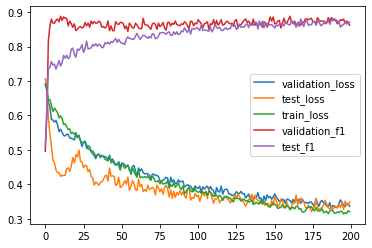

In [143]:
x=list(range(0,200))
plt.plot(x,Loss_validation,label='validation_loss')
plt.plot(x,Loss_test,label='test_loss')
plt.plot(x,Loss_train,label='train_loss')

plt.plot(x,f1_test,label='validation_f1')
plt.plot(x,f1_validation,label='test_f1')

plt.legend()
plt.show()

In [142]:
Acc_test[-1:]
Loss_validation[-1:]
Loss_test[-1:]
Acc_validation[-1:]
f1_test[-1:]
f1_validation[-1:]

[0.8809090909090909]

[0.3359028100967407]

[0.3481695353984833]

[0.8809090909090909]

[0.8619999999999999]

[0.8709090909090909]

In [198]:
Counter(a.label)

Counter({0: 2552, 1: 325})

In [199]:
Counter(label)

Counter({0: 2552, 1: 1041})

In [201]:
len(label)

3593

In [205]:
dflabel=pd.DataFrame(a.label)

In [206]:
len(dflabel)

2877